<font size="+3">Monitor : BindCraft Designs in Funnel Metadynamics  </font>


In [1]:
import pandas as pd
import numpy as np
import os
import MDAnalysis as mda
from MDAnalysis.analysis import rms
import warnings
warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import glob


from pandas.api.types import CategoricalDtype

/Users/roessner/miniconda3/envs/wheeler/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
def plot_adjust_settings(xlabel, ylabel, ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.set_xlabel(xlabel,fontsize=11,labelpad=7)
    ax.set_ylabel(ylabel,fontsize=11,labelpad=7)
    ax.tick_params(labelsize=9, pad=5)
    

# Download

In [ ]:
%%bash
clst_dir=$( echo /scratch/nickel/260109_duo_design_CXCR4_funnel/ )
target_dir=$( echo /Users/roessner/Documents/PostDoc/Data/260109_duo_design_CXCR4_funnel )

#rsync -avz --include='reimage.*' --include='HILLS' --include='BIAS' --include='COLVAR' --include='*/' --exclude='*' nickel@172.19.48.4:$clst_dir $target_dir
rsync -avz --include='HILLS' --include='BIAS' --include='COLVAR' --include='*/' --exclude='*' nickel@kuma1.hpc.epfl.ch:$clst_dir $target_dir

rsync error: received SIGINT, SIGTERM, or SIGHUP (code 20) at /AppleInternal/Library/BuildRoots/bc10cbcd-3cda-11ee-b8ac-16228a05f5d2/Library/Caches/com.apple.xbs/Sources/rsync/rsync/rsync.c(244) [receiver=2.6.9]


Process is interrupted.


# Free Energy Profile

In [3]:
%%bash
pwd=$(pwd)

declare -a params=( human mouse )

for batch in "${params[@]}"
do
    cd $batch
    for dir in */
    do
        binder=${dir%/}
        for i in {0..2}
        do
            dir="$pwd/$batch/$binder/$i"
            cd $dir
            plumed sum_hills --hills HILLS --outfile fes.dat 
            # every 10 ns
            rm -r FES
            mkdir FES
            plumed sum_hills --hills HILLS --outfile FES/fes. --stride 10000 --mintozero 
        done
    done
    cd $pwd
done

PLUMED: PLUMED is starting
PLUMED: Version: 2.9.2 (git: Unknown) compiled on Sep  4 2024 at 12:28:06
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /Users/roessner/miniconda3/envs/wheeler/lib/plumed
PLUMED: For installed feature, see /Users/roessner/miniconda3/envs/wheeler/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished se

# Convergence

In [ ]:
batches = ['human', 'mouse']
           
for i in batches:
    binders = [b for b in os.listdir(f'{i}') if os.path.isdir(f'{i}/{b}')]
    binders.sort()

    lst=[]
    for binder in binders:
        for j in range(3):
            ndir = f'{i}/{binder}/{j}/FES'
            files = [f for f in os.listdir(ndir) if os.path.isfile(os.path.join(ndir, f))]

            # rename and sort files
            for f in files:
                x = int(f.split(".")[1])
                dst = os.path.join(ndir, "fes.{0:04d}.dat".format(x))
                src = os.path.join(ndir, f) 
                os.rename(src, dst) 
                
            files = glob.glob(f'{ndir}/*.dat')
            files.sort()
            
            for f in files:
                df = pd.DataFrame()
                arr = np.loadtxt(f)               
                df["d"] = arr[:,0]
                df["fes"] = arr[:,1]
                df["step"] = f.split(".")[1]
                df["time"] = int(int(f.split(".")[1])*5) +5
                df['rep'] = j
                df['binder'] = binder
                lst.append(df)
        
    df = pd.concat(lst)
    df.to_pickle(f'fes-convergence-{i}.pkl')

Text(0.5, 0, 'Distance [nm]')

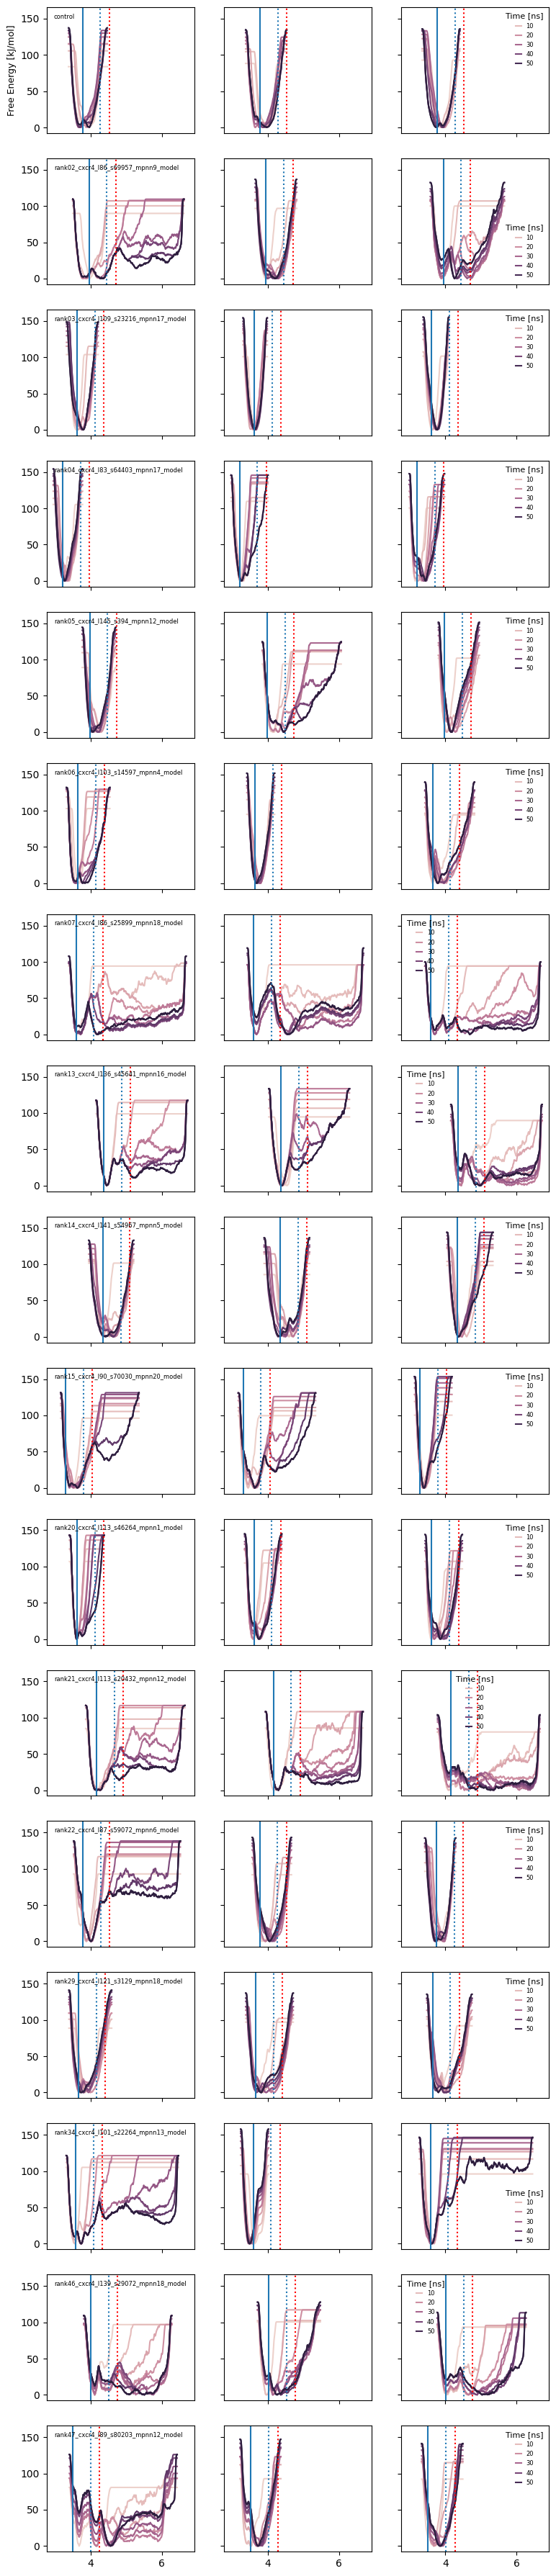

In [13]:
fig, axes = plt.subplots(17,3,figsize=(9,2.7*17), sharex=True, sharey=True)
batch = 'human'
df = pd.read_pickle(f'fes-convergence-{batch}.pkl')

for cnt, (name, group) in enumerate(df.groupby('binder')):
    for i in range(3):
        ax = axes[cnt][i]
        
        df_rep = group[group['rep'] == i]     
        sns.lineplot(df_rep, x='d', y='fes', hue='time', ax=ax)
        
        if i == 2:
            ax.legend(title='Time [ns]', title_fontsize=8, fontsize=6, frameon=False, handlelength=1)
        else:
            ax.legend([],[], frameon=False)

        ax.set_ylabel("")
        ax.set_xlabel("")
        
        # initial distance
        file = f'{batch}/{name}/{i}/COLVAR'
        if os.path.exists(file):
            df = pd.DataFrame()
            arr = np.loadtxt(file)
            dim = len(arr.shape)
            if dim == 1:
                pass
            else:
                init = arr[0,1]  
                ax.axvline(init)
                ax.axvline(init+0.5, linestyle=':', label='end bound')
                ax.axvline(init+0.75, linestyle=':', label='start unbound', color='red')
        #ax.set_xlim(0,6)
        
    # Add text in the lower right
    axes[cnt][0].text(0.05, 0.95, name, transform=axes[cnt][0].transAxes, fontsize=6, ha='left', va='top')
    
axes[0][0].set_ylabel("Free Energy [kJ/mol]", fontsize=9)
axes[4][0].set_xlabel("Distance [nm]", fontsize=9)

# Binding Free Energy

In [11]:
def compute_FES(file, t_bound, t_unbound):
    # Constants
    kBT = 2.479  # in kJ/mol at 300 K
    V_ref = 1.661  # reference volume in nm^3 (1 mol/L)
    beta = 1 / kBT

    # Load FES: column 0 = fps.lp, column 1 = F (free energy)
    fes = np.loadtxt(file)
    z = fes[:, 0]
    F = fes[:, 1]

    # Bound region (adjust as needed)
    bound = (z > 0) & (z < t_bound)
    unbound = z > t_unbound

    # Integrate partition functions
    Z_bound = np.trapz(np.exp(-beta * F[bound]), z[bound])
    Z_unbound = np.trapz(np.exp(-beta * F[unbound]), z[unbound])

    # Binding free energy
    deltaG = -kBT * np.log(Z_bound / (Z_unbound * V_ref))
    #print(f"ΔG_bind = {deltaG:.2f} kJ/mol")
    return deltaG


In [24]:
batches = ['human', 'mouse']

dico = {'binder':[],
        'target':[],
       'rep':[],
       'deltaG':[]}

for i in batches:
    binders = [b for b in os.listdir(f'{i}') if os.path.isdir(f'{i}/{b}')]
    binders.sort()

    lst=[]
    for binder in binders:
        for j in range(3):
            ndir = f'{i}/{binder}/{j}/FES'
                
            files = glob.glob(f'{ndir}/*.dat')
            files.sort()

            if len(files) < 5:
                print(i, len(files))
            else:
                # initial distance
                colvar = f'{i}/{binder}/{j}/COLVAR'
                init = np.loadtxt(colvar)[0,1]
        
                deltaG = compute_FES(files[-1], t_bound=init+0.5, t_unbound=init+0.75)
                
                if deltaG == float('-inf'):
                    deltaG = -100
                elif deltaG < -100:
                    deltaG = -100
                else:
                    pass
          
                dico['binder'].append(binder)
                dico['target'].append(i)
                dico['rep'].append(j)
                dico['deltaG'].append(deltaG)

df = pd.DataFrame(dico)
df.to_pickle('deltaG.pkl')
df

,binder,target,rep,deltaG
0,control,human,0,-100.000000
1,control,human,1,-100.000000
2,control,human,2,-100.000000
3,rank02_cxcr4_l86_s69957_mpnn9_model,human,0,-14.150530
4,rank02_cxcr4_l86_s69957_mpnn9_model,human,1,-100.000000
...,...,...,...,...
94,rank46_cxcr4_l139_s29072_mpnn18_model,mouse,1,-35.207177
95,rank46_cxcr4_l139_s29072_mpnn18_model,mouse,2,5.154182
96,rank47_cxcr4_l89_s80203_mpnn12_model,mouse,0,-76.547854
97,rank47_cxcr4_l89_s80203_mpnn12_model,mouse,1,11.499410


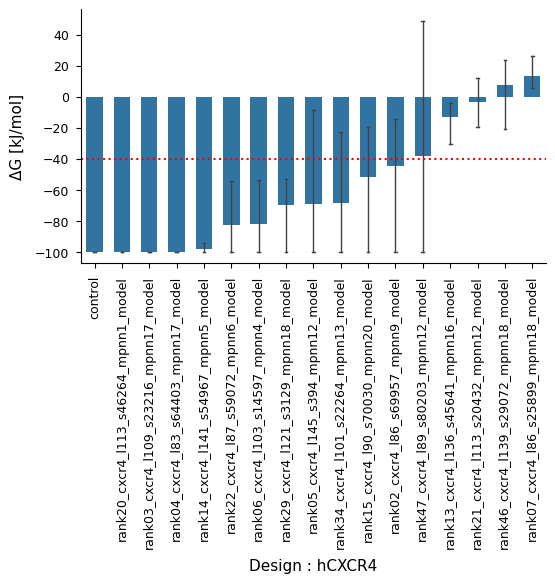

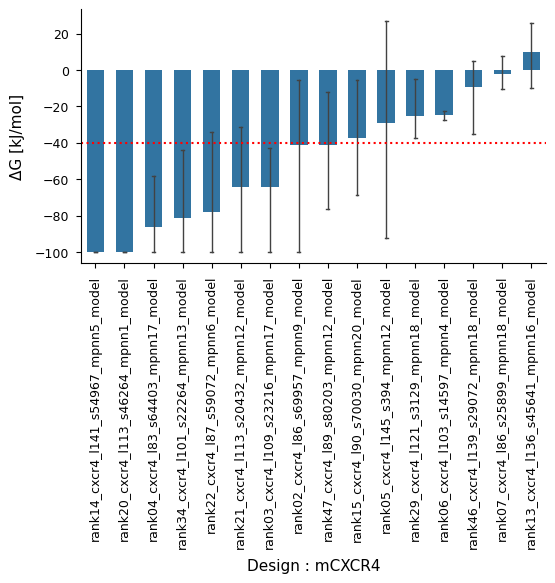

In [33]:
df_all = pd.read_pickle('deltaG.pkl')

for name, df in df_all.groupby('target'):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3.3))

    df_avg = df.groupby(['binder'], as_index=False)['deltaG'].mean()
    df_best = df_avg.groupby('binder')['deltaG'].min().sort_values()
    order = df_best.index.tolist()

    sns.barplot(df, x='binder', y='deltaG', ax=ax,
                errwidth=1, capsize=0.1, width=0.6, order=order)

    plot_adjust_settings(f'Design : {name[0]}CXCR4', 'ΔG [kJ/mol]')
    ax.legend(frameon=False, title='', handlelength=0.5, loc='lower right')
    ax.tick_params(axis='x', rotation=90)
    sns.despine()
    ax.axhline(-40, color='red', linestyle=':')
    #ax.set_ylim(-130, 10)

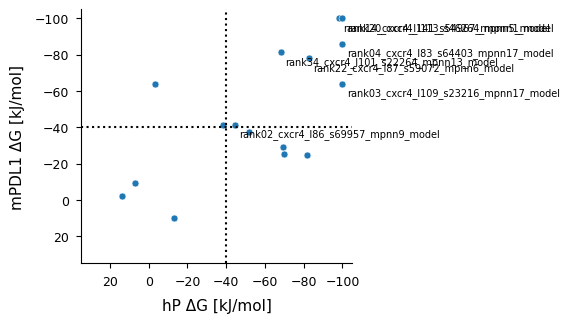

In [55]:
df = pd.read_pickle('deltaG.pkl')

# per binder (averaged over replicas)
agg = (df.groupby(['binder', 'target'])
         .agg(mean_deltaG=('deltaG','mean'),
              std_deltaG=('deltaG','std'))
         .reset_index())

lst=[]
for name, df in agg.groupby('target'):
    df = df.rename(columns={
        'mean_deltaG': f'{name}_mean_deltaG',
        'std_deltaG':  f'{name}_std_deltaG'
    })
    df = df.drop(columns=['target'])

    lst.append(df)

df = pd.merge(lst[0], lst[1], on=['binder'])

# plot
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.3))
sns.scatterplot(df, x='human_mean_deltaG', y='mouse_mean_deltaG', ax=ax, s=25)

plot_adjust_settings('hP ΔG [kJ/mol]', 'mPDL1 ΔG [kJ/mol]')
ax.legend(bbox_to_anchor=(1,0.4), frameon=False, loc='upper left')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlim(35, -105)
ax.set_ylim(35, -105)
sns.despine()
ax.axhline(-40, color='black', linestyle=':')
ax.axvline(-40, color='black', linestyle=':')

# labels
mask = (df['human_mean_deltaG'] < -40) & (df['mouse_mean_deltaG'] < -40)
for _, r in df[mask].iterrows():
    ax.annotate(r['binder'],
                (r['human_mean_deltaG'], r['mouse_mean_deltaG']),
                textcoords='offset points', xytext=(3, -3), ha='left', va='top',
                fontsize=7)

# annotate data frame
# binding
conditions = [
    (df['human_mean_deltaG'] < -40) & (df['mouse_mean_deltaG'] < -40),  # both
    (df['human_mean_deltaG'] < -40) & (df['mouse_mean_deltaG'] >= -40), # human only
    (df['human_mean_deltaG'] >= -40) & (df['mouse_mean_deltaG'] < -40)  # mouse only
]
choices = ['both', 'human', 'mouse']
df['binding'] = np.select(conditions, choices, default='none')

# testing
df = df.sort_values(by=['human_mean_deltaG', 'mouse_mean_deltaG'])
df['test'] = np.where(
    (df['human_mean_deltaG'] < -60) & (df['mouse_mean_deltaG'] < -60),
    'yes',
    'no'
)

# sequence
sequences = pd.read_csv('human/CXCR4-human.csv')
df = pd.merge(df, sequences, left_on='binder', right_on='Design')
df.to_csv("CXCR4_duo_designs.csv", index=False)